In [ ]:
#@title Presentación
from IPython.display import display, HTML

# HTML para la portada
html_code = """
<div style="
    background-color: #f4f4f4;
    border-radius: 15px;
    padding: 30px;
    text-align: center;
    font-family: Arial, sans-serif;
    color: #333;
    box-shadow: 0px 4px 10px rgba(0, 0, 0, 0.2);">
    <h1 style="color: #4CAF50; font-size: 50px;">Microproyecto 4 - Clasificación de vehículos</h1>
    <h2 style="color: #555;">Equipo 9</h2>
    <hr style="border: none; height: 2px; background-color: #4CAF50; margin: 20px auto; width: 50%;">
    <h3 style="color: #222; margin: 10px 0;">Estudiantes:</h3>
    <ul style="list-style: none; padding: 0; font-size: 20px;">
        <li>Luis Alejandro Varela Ojeda</li>
        <li>Juan Manuel Rodríguez Sánchez</li>
        <li>Jacobo Ochoa Ramírez</li>
    </ul>
</div>
"""

# Mostrar la portada
display(HTML(html_code))


##Descarga de Datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download mrtontrnok/5-vehichles-for-multicategory-classification

Dataset URL: https://www.kaggle.com/datasets/mrtontrnok/5-vehichles-for-multicategory-classification
License(s): CC0-1.0
100% 465M/465M [00:24<00:00, 23.3MB/s]
100% 465M/465M [00:24<00:00, 20.1MB/s]


##Librerías necesarias

In [ ]:
!pip install tensorflow -q
!pip install visualkeras -q
!pip install albumentations -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 48.1 MB/s eta 0:00:00


In [ ]:
import os
import json
import zipfile
import shutil
import datetime
import kagglehub
import numpy as np
from numpy import expand_dims
import pandas as pd
from PIL import Image
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import visualkeras
from collections import Counter
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, SpatialDropout2D, GlobalAveragePooling2D

In [ ]:
# Setear semillas
tf.random.set_seed(9)
np.random.seed(9)

# Definir el tamaño de las imágenes
img_size = 80

##Generar clave de validación de Kaggle

In [ ]:
data = {"username": "jacoboochoaramirez", "key": "98177871864492be37381ec7fdbe3bab"}

with open("kaggle.json", "w") as json_file:
    json.dump(data, json_file)

##Lectura, encoding y redimensión de las imágenes

In [ ]:
def extract_images():
    zip_path = "/content/5-vehichles-for-multicategory-classification.zip"

    X = []
    y = []

    classDict = {
        "bus": 0,
        "car": 1,
        "motorcycle": 2,
        "train": 3,
        "truck": 4
    }

    # Open zip file without extracting
    with zipfile.ZipFile(zip_path, 'r') as zip_file:
        for file in zip_file.namelist():
            # Skip directories
            if file.endswith("/"):
                continue

            # Extract category
            parts = file.split("/")
            if len(parts) >= 3:
                vehicle_category = parts[2]

                if vehicle_category in classDict:
                    try:
                        with zip_file.open(file) as src:
                            img = Image.open(src).convert('RGB')
                            img = img.resize((img_size, img_size))
                            X.append(np.array(img))
                            y.append(classDict[vehicle_category])
                    except Exception as e:
                      continue


    return (np.array(X).astype('float32') / 255.0), np.array(y) #normalizar


X, y = extract_images()
print("Dataset loaded:", X.shape, y.shape)

Dataset loaded: (6835, 80, 80, 3) (6835,)


##Separación de datos en Entrenamiento, Prueba y Validación

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

In [ ]:
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, train_size=0.5, shuffle=True)

## Distribución de Clases


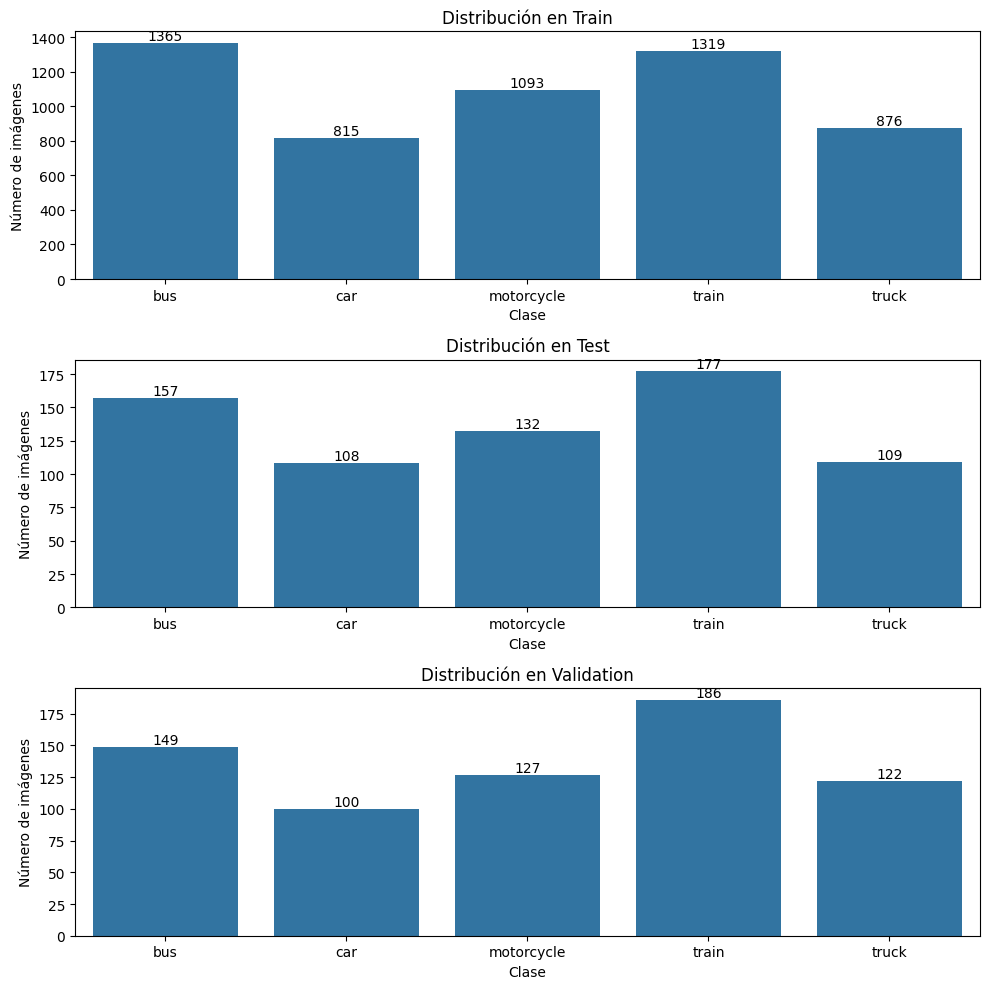

In [ ]:

class_labels = ["bus", "car", "motorcycle", "train", "truck"]

# Increase figure height to prevent bars from overlapping
plt.figure(figsize=(10, 10))

# Train
plt.subplot(3, 1, 1)
train_dist = pd.Series(Y_train).value_counts().sort_index()
ax = sns.barplot(x=train_dist.index, y=train_dist.values)
ax.set_title('Distribución en Train')
ax.set_xlabel('Clase')
ax.set_ylabel('Número de imágenes')
ax.set_xticks(train_dist.index)  # Fix alignment
ax.set_xticklabels(class_labels)

# Add value labels on bars
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom')

# Test
plt.subplot(3, 1, 2)
test_dist = pd.Series(Y_test).value_counts().sort_index()
ax = sns.barplot(x=test_dist.index, y=test_dist.values)
ax.set_title('Distribución en Test')
ax.set_xlabel('Clase')
ax.set_ylabel('Número de imágenes')
ax.set_xticks(test_dist.index)
ax.set_xticklabels(class_labels)

for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom')

# Validation
plt.subplot(3, 1, 3)
val_dist = pd.Series(Y_val).value_counts().sort_index()
ax = sns.barplot(x=val_dist.index, y=val_dist.values)
ax.set_title('Distribución en Validation')
ax.set_xlabel('Clase')
ax.set_ylabel('Número de imágenes')
ax.set_xticks(val_dist.index)
ax.set_xticklabels(class_labels)

for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


## Balanceo de Datos de Entrenamiento


In [ ]:
# Contar imágenes por clase en el conjunto de entrenamiento
conteo_clases = Counter(Y_train)
max_clase = max(conteo_clases.values())  # Número máximo de imágenes en una clase

In [ ]:
# Aumento de imágenes
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Balancear las clases con menos imágenes
X_train_bal = []
Y_train_bal = []

for clase, num_imgs in conteo_clases.items():
    X_clase = X_train[Y_train == clase]  # Filtrar imágenes de la clase actual
    Y_clase = np.full((len(X_clase)), clase)  # Etiquetas

    # Agregar imágenes originales
    X_train_bal.extend(X_clase)
    Y_train_bal.extend(Y_clase)

    # Generar imágenes si hay menos que el máximo
    num_to_generate = max_clase - num_imgs
    if num_to_generate > 0:
        # X_clase = X_clase# Ajustar forma si es necesario
        aug_iter = datagen.flow(X_clase, Y_clase, batch_size=1)

        for _ in range(num_to_generate):
            aug_img, aug_label = next(aug_iter)
            X_train_bal.append(aug_img[0])
            Y_train_bal.append(aug_label[0])

# Convertir listas a arrays
X_train_bal = np.array(X_train_bal)
Y_train_bal = np.array(Y_train_bal)

print("Nueva distribución de clases en entrenamiento:", Counter(Y_train_bal))

Nueva distribución de clases en entrenamiento: Counter({2: 1365, 4: 1365, 0: 1365, 1: 1365, 3: 1365})


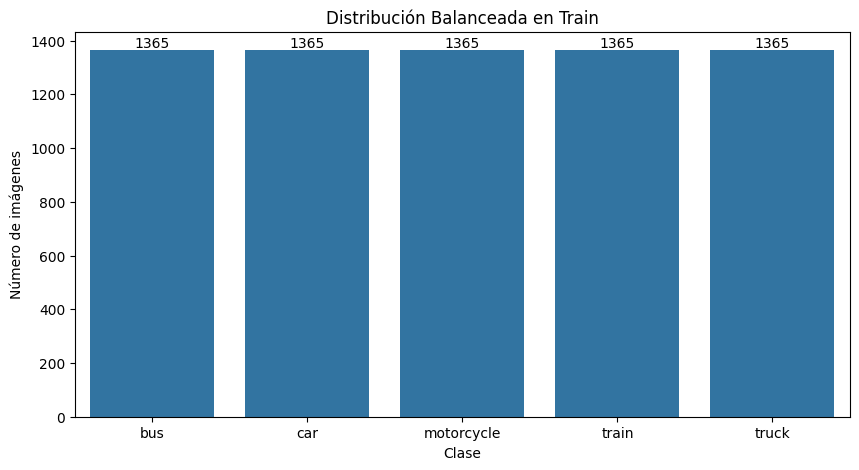

In [ ]:
# Etiquetas de las clases
class_labels = ["bus", "car", "motorcycle", "train", "truck"]

# Contar imágenes por clase en el conjunto balanceado
train_bal_dist = pd.Series(Y_train_bal).value_counts().sort_index()

# Crear la gráfica
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=train_bal_dist.index, y=train_bal_dist.values)
ax.set_title('Distribución Balanceada en Train')
ax.set_xlabel('Clase')
ax.set_ylabel('Número de imágenes')
ax.set_xticks(train_bal_dist.index)
ax.set_xticklabels(class_labels)

# Agregar etiquetas en las barras
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom')

plt.show()

##Arquitectura del Modelo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


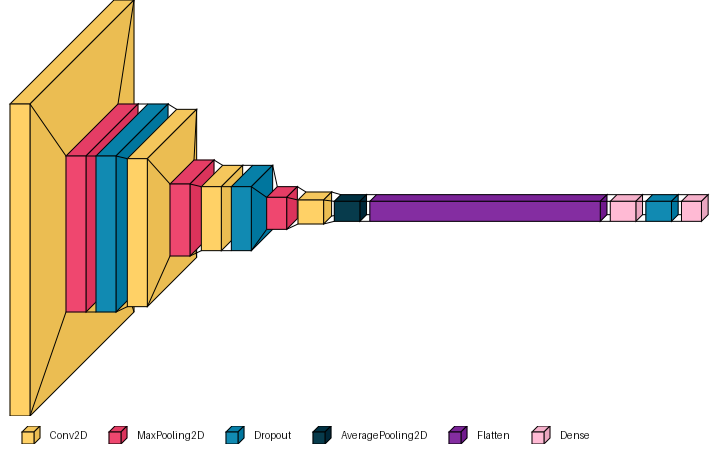

In [ ]:
model = tf.keras.Sequential([
    # Bloque 1
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3), name='block1_conv'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.1),

    # Bloque 2
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', name='block2_conv'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Bloque 3
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', name='block3_conv'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.MaxPooling2D(2,2),

    # Bloque 4
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', name='block4_conv'),
    tf.keras.layers.AveragePooling2D(2,2),

    # Capas densas
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(5, activation='softmax')  # 5 clases
])

visualkeras.layered_view(model, legend=True)

##Compilación del Modelo

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv (Conv2D)                 │ (None, 78, 78, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 39, 39, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 39, 39, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv (Conv2D)                 │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv (Conv2D)                 │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv (Conv2D)                 │ (None, 6, 6, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 979,781 (3.74 MB)

 Trainable params: 979,781 (3.74 MB)

 Non-trainable params: 0 (0.00 B)

##Callbacks


In [ ]:
directory = "/content/drive/Shareddrives/IA/Microproyectos/MicroProyecto4/ModelosGuardados"

now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
os.makedirs(directory, exist_ok=True)

# Guarda un registro de las métricas en un archivo .csv
csv_logger = CSVLogger(os.path.join(directory, f"training_metrics_{now}.csv"))

# Detiene el entrenamiento del modelo cuando no se observa gran mejoría
early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5, restore_best_weights = True)

# Reduce la tasa de aprendizaje cuando el aprendizaje del modelo se estanca
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=5)

# Guarda el mejor modelo que se genere
model_checkpoint = ModelCheckpoint(os.path.join(directory, f"best_model_{now}.keras"), save_best_only=True, monitor='val_accuracy')

##Entrenamiento del Modelo

In [ ]:
history = model.fit(datagen.flow(X_train_bal, Y_train_bal, batch_size=48),
          epochs=100,
          validation_data=(X_val, Y_val),
          callbacks=[csv_logger, early_stopping, reduce_lr_on_plateau, model_checkpoint])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 150ms/step - accuracy: 0.2534 - loss: 1.5815 - val_accuracy: 0.4561 - val_loss: 1.3541 - learning_rate: 0.0010
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - accuracy: 0.3987 - loss: 1.4205 - val_accuracy: 0.5292 - val_loss: 1.2334 - learning_rate: 0.0010
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - accuracy: 0.4529 - loss: 1.3231 - val_accuracy: 0.5541 - val_loss: 1.1945 - learning_rate: 0.0010
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - accuracy: 0.4970 - loss: 1.2537 - val_accuracy: 0.5848 - val_loss: 1.0139 - learning_rate: 0.0010
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.5125 - loss: 1.2000 - val_accuracy: 0.5994 - val_loss: 0.9799 - learning_rate: 0.0010
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - accuracy: 0.5644 - loss: 1.0922 - val_accuracy: 0.6111 - val_loss: 1.0003 - learning_rate: 0.0010
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0

## Guardado del Modelo y Métricas

In [ ]:
model.save(os.path.join(directory, f"final_model_{now}.keras"))

In [ ]:
metrics_path = os.path.join(directory, f"metrics_{now}.json")

with open(metrics_path, 'w') as f:
    json.dump(history.history, f, indent=4)

##Funciones de Pérdida y Exactitud

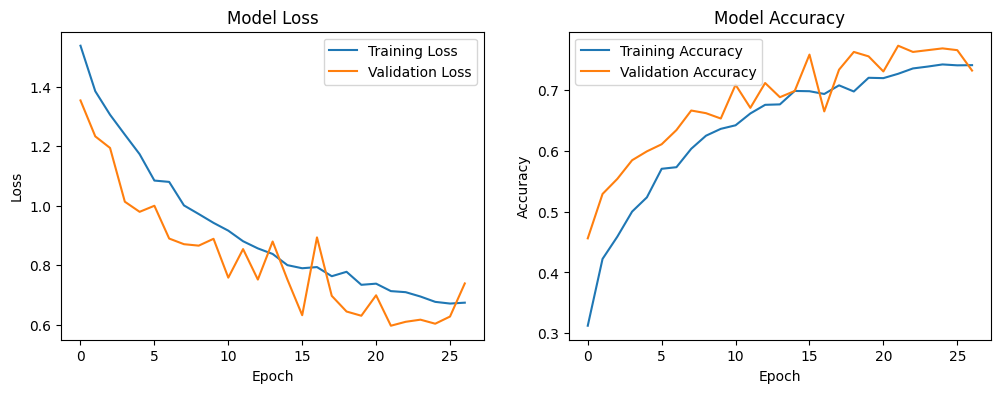

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##Matriz de Confusión

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


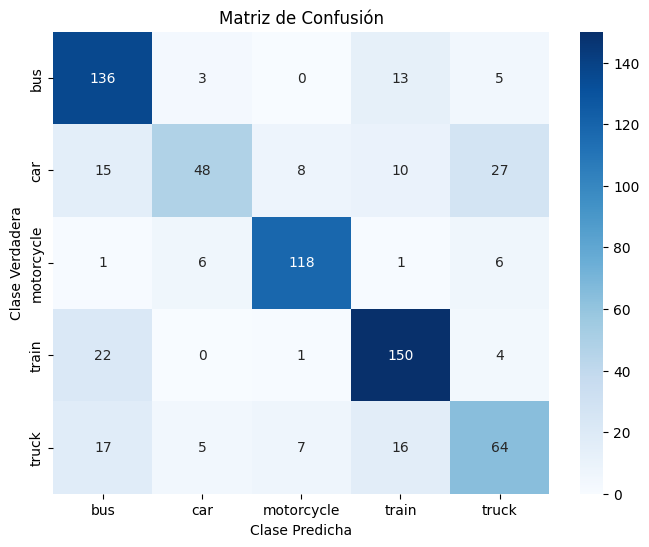

In [ ]:
# Obtener las etiquetas de clase predichas
y_pred_probs = model.predict(X_test)  # El modelo devuelve probabilidades de pertenencia a cada clase
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Obtener la clase con mayor probabilidad

# Calcular la matriz de confusión
cm = confusion_matrix(Y_test, y_pred_classes)

# Definir las etiquetas de las clases
class_labels = ["bus", "car", "motorcycle", "train", "truck"]

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Matriz de Confusión')
plt.ylabel('Clase Verdadera')
plt.xlabel('Clase Predicha')
plt.show()

##Métricas de desempeño

In [ ]:
print(classification_report(Y_test, y_pred_classes, target_names=["bus", "car", "motorcycle", "train", "truck"]))


Reporte de Clasificación Detallado:
              precision    recall  f1-score   support

         bus       0.71      0.87      0.78       157
         car       0.77      0.44      0.56       108
  motorcycle       0.88      0.89      0.89       132
       train       0.79      0.85      0.82       177
       truck       0.60      0.59      0.60       109

    accuracy                           0.76       683
   macro avg       0.75      0.73      0.73       683
weighted avg       0.76      0.76      0.75       683



#Análisis resultados (CNN)
El modelo CNN logra una exactitud global del 76%, lo que indica un rendimiento razonable en la clasificación de vehículos. No obstante, su capacidad para identificar correctamente cada tipo varía, con algunas clases mostrando alta precisión y otras enfrentando dificultades debido a similitudes visuales entre los vehículos. A continuación, se analiza en detalle la mejor y la peor clase clasificada.

La clase mejor clasificada es: "motorcycle"
- F1-score: 0.89 (el más alto de todas las clases).
- Precisión: 0.88 → Cuando el modelo predice "motorcycle", el 88% de las veces es correcto.
- Recall: 0.89 → El 89% de las motocicletas reales fueron identificadas correctamente.
- Confusiones: Se confundió 6 veces con "car" y en menor medida con "bus" y "truck" (1 vez cada una).
- Conclusión: El modelo clasifica con gran precisión las motocicletas, con un bajo número de errores.

La clase peor clasificada: "car"
- F1-score: 0.56 (el más bajo de todas las clases).
- Precisión: 0.77 → Cuando el modelo predice "car", el 77% de las veces es correcto.
- Recall: 0.44 → Solo el 44% de los autos reales fueron identificados correctamente.
- Confusiones: Se confunde con "bus" (15), "motorcycle" (8), "train" (10) y especialmente con "truck" (27), lo que sugiere dificultades en distinguirlos.
- Conclusión: La clasificación de automóviles presenta el mayor desafío para el modelo, con una fuerte tendencia a confundirlos con camiones y otros vehículos.

## Ejemplos de Resultados de Predicción

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


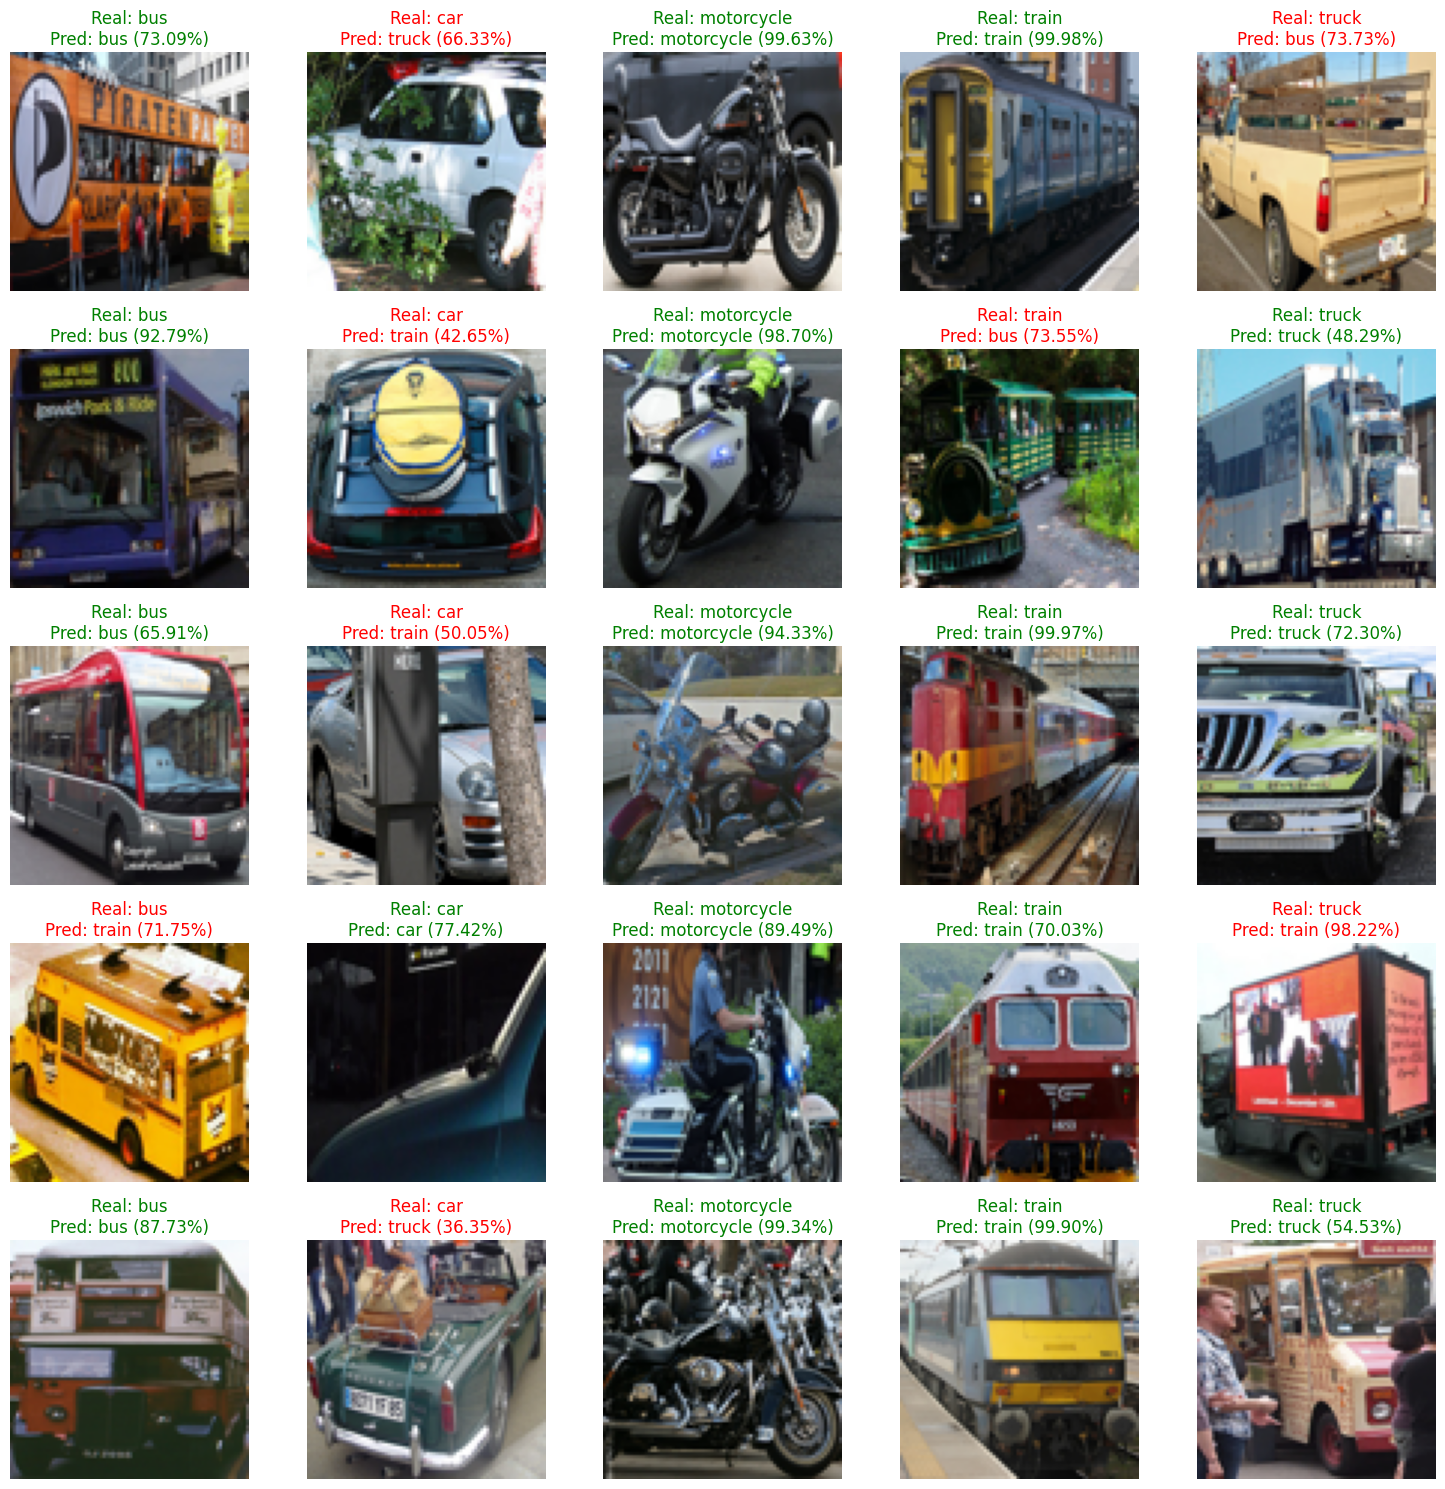

In [ ]:
# Lista de nombres de clases en el mismo orden que el entrenamiento
class_labels = ["bus", "car", "motorcycle", "train", "truck"]

def show_predictions(model, test_data, test_labels, num_images_per_class=5):
    predictions = model.predict(test_data)  # Matriz (N, 5), donde cada fila es un vector de 5 probabilidades

    num_classes = len(class_labels)
    fig, axes = plt.subplots(num_images_per_class, num_classes, figsize=(num_classes * 3, num_images_per_class * 3))

    for class_idx, class_name in enumerate(class_labels):
        class_images = np.where(test_labels == class_idx)[0]  # Encuentra los índices de imágenes de la clase actual
        selected_images = np.random.choice(class_images, num_images_per_class, replace=False)  # Selecciona imágenes al azar

        for row, img_idx in enumerate(selected_images):
            ax = axes[row, class_idx]  # Selecciona la celda correspondiente en la cuadrícula

            ax.imshow(test_data[img_idx])  # Muestra la imagen

            pred_idx = np.argmax(predictions[img_idx])  # Índice de la clase predicha
            true_idx = test_labels[img_idx]  # Índice de la clase real

            pred_label = class_labels[pred_idx]
            true_label = class_labels[true_idx]
            pred_prob = predictions[img_idx][pred_idx]  # Probabilidad de la clase predicha

            color = "green" if pred_idx == true_idx else "red"
            ax.set_title(f'Real: {true_label}\nPred: {pred_label} ({pred_prob:.2%})', color=color)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Llamar a la función con 5 imágenes por clase
show_predictions(model, X_test, Y_test, num_images_per_class=5)

##Feature Map

In [ ]:
img_index = 245
img = X_train_bal[img_index]
img = expand_dims(img, axis=0)
model_for_features = Model(inputs=model.inputs, outputs=model.layers[0].output)

##Imagen de Referencia

(-0.5, 79.5, 79.5, -0.5)

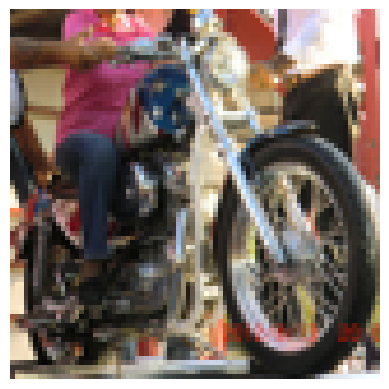

In [ ]:
img_vis = img[0]

plt.imshow(img_vis)
plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


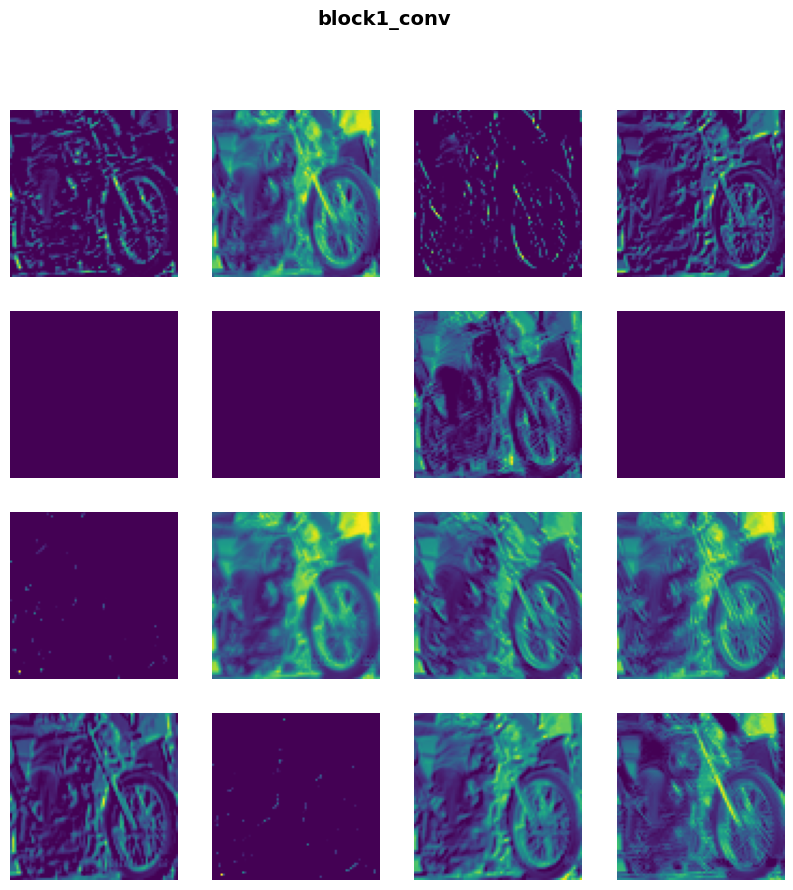

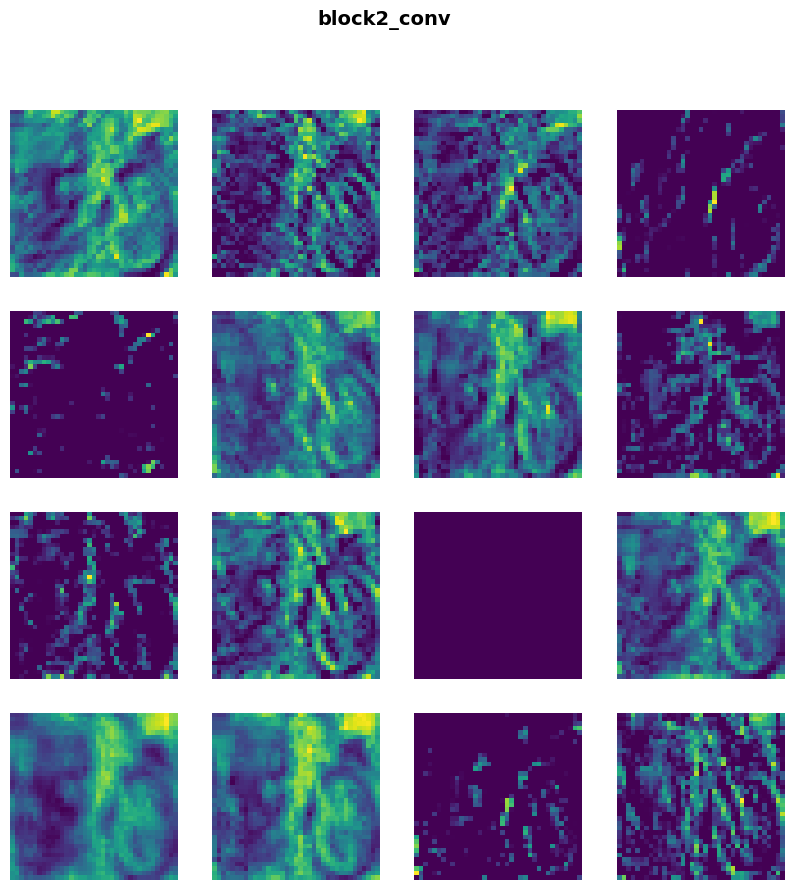

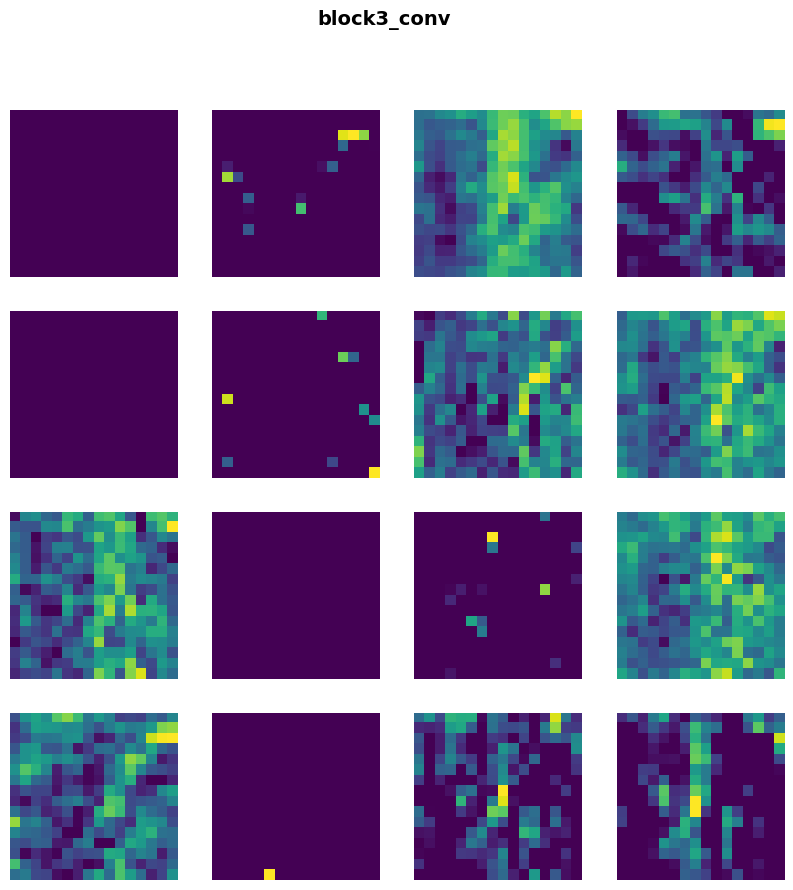

In [ ]:
# Seleccionar una imagen de entrenamiento
img = X_train_bal[img_index]

# Expandir dimensiones para que sea (1, height, width, channels)
img = expand_dims(img, axis=0)

# Encontrar todas las capas convolucionales
conv_layers = [layer for layer in model.layers if 'conv' in layer.name][:3]

# Crear un modelo que devuelva las salidas de todas las capas convolucionales
outputs = [layer.output for layer in conv_layers]
model_for_features = Model(inputs=model.inputs, outputs=outputs)

# Obtener los mapas de características
feature_maps = model_for_features.predict(img)

# Graficar cada conjunto de feature maps por capa
for layer_idx, fmap in enumerate(feature_maps):
    fmap = fmap[0]  # Eliminar la dimensión del batch
    layer_name = conv_layers[layer_idx].name  # Nombre de la capa
    num_filters = fmap.shape[-1]  # Número total de filtros en la capa

    # Definir el tamaño de la cuadrícula (4x4)
    square = 4
    num_to_display = min(square * square, num_filters)  # Máximo 16 imágenes por capa

    fig, axes = plt.subplots(square, square, figsize=(10, 10))
    fig.suptitle(layer_name, fontsize=14, fontweight="bold")

    for i in range(square * square):
        ax = axes[i // square, i % square]  # Seleccionar subgráfico
        ax.axis("off")

        if i < num_to_display:
            ax.imshow(fmap[:, :, i], cmap="viridis")  # Mostrar filtro

    plt.show()


Los resultados de esta capa son difícilmente reconocibles. Hay que tomar en cuenta que esta es una fracción muy pequeña de los resultados que se consiguen en esta capa, por lo que  algunas estructuras y patrones más evidentes puede que sean más claros en los resultados no vistos.

##Interpretación Feature Map

1.  **Primera Capa Convolucional (block1_conv)**:

En esta primera capa se puede ver algunos de los resultados destacando los bordes y contornos de la imagen con varios grados de intensidad. Otros resaltan la figura de la moto y agrupa piezas grandes de esta, ignorando texturas y bordes. Finalmente otros de los resultados dejan ver mejor las texturas en la imagen y las zonas luminosas.


2.  **Segunda Capa Convolucional (block2_conv)**:

En general los resultados de esta capa son mucho más abstractos. Algunas formas aún son reconocibles, en especial la forma de la llanta frontal y el farol de la moto, indicando que estas características pueden ser más importantes para la clasificación. También destaca texturas más complejas y algunas combinaciones de bordes.

3.  **Tercera Capa Convolucional (block3_conv)**:

Los resultados de esta capa son difícilmente reconocibles. Hay que tomar en cuenta que esta es una fracción muy pequeña de los resultados que se consiguen en esta capa, por lo que  algunas estructuras y patrones significativos puede que sean más claros en los resultados no vistos. Se pueden ver texturas y estructuras mucho más complejas dentro de la imagen.



Capa 1 → Detecta bordes y contornos básicos.

Capa 2 → Aprende patrones más complejos como texturas y estructuras.

Capa 3 → Extrae características específicas de objetos para la clasificación.


#Modelo Preentrenado (Resnet-50)

In [ ]:
input_shape = (80, 80, 3)
number_classes = 5
model_name = "modelo_preentrenado"
initial_lr = 0.001

def create_custom_resnet50(resnet50_input_shape, number_classes, model_name, initial_lr, block_pretrained_layers=False):

  # Se carga una CNN con arquitectura ResNet50 preentrenada en ImageNet.
  resnet50_model_base = ResNet50(include_top=False, weights="imagenet", input_shape=resnet50_input_shape)

  if block_pretrained_layers:
    # Se impide que las capas preentrenadas sean entrenables.
    for layer in resnet50_model_base.layers:
      layer.trainable = False

  # Se agrega una capa de pooling de tipo global average.
  x = resnet50_model_base.output
  x = GlobalAveragePooling2D(name="avg_pool")(x)

  # Se agrega una densa con función de activación sigmoide.
  outputs = Dense(number_classes, activation="softmax", name="fc8")(x)

  # Se ensambla el modelo a usar.
  model = Model(inputs=resnet50_model_base.input, outputs=outputs, name=model_name)

  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

  return model

# Creación del modelo
model_v1 = create_custom_resnet50(input_shape, number_classes, model_name, initial_lr)

##Resumen del modelo preentrenado

In [ ]:
model_v1.summary()

Model: "modelo_preentrenado"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 80, 80, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 86, 86, 3)      │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 40, 40, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 40, 40, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 40, 40, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 42, 42, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 20, 20, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 20, 20, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 20, 20, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 20, 20, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 20, 20, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 20, 20, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 20, 20, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 20, 20, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 20, 20, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 23,544,837 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
history_model_v1 = model_v1.fit(datagen.flow(X_train_bal, Y_train_bal, batch_size=48),
          epochs=100,
          validation_data=(X_val, Y_val),
          callbacks=[csv_logger, early_stopping, reduce_lr_on_plateau, model_checkpoint])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 108s 334ms/step - accuracy: 0.5207 - loss: 1.5204 - val_accuracy: 0.1857 - val_loss: 14.5972 - learning_rate: 0.0010
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 133ms/step - accuracy: 0.5547 - loss: 1.1511 - val_accuracy: 0.1462 - val_loss: 1.8805 - learning_rate: 0.0010
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.6788 - loss: 0.8316 - val_accuracy: 0.1462 - val_loss: 1.8899 - learning_rate: 0.0010
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.7305 - loss: 0.7216 - val_accuracy: 0.1462 - val_loss: 2.2058 - learning_rate: 0.0010
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.7521 - loss: 0.6568 - val_accuracy: 0.3056 - val_loss: 1.4814 - learning_rate: 0.0010
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step - accuracy: 0.7803 - loss: 0.5945 - val_accuracy: 0.6374 - val_loss: 0.9696 - learning_rate: 0.0010
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - accuracy: 0.7929

##Funciones de Pérdida y Exactitud del modelo preentrenado

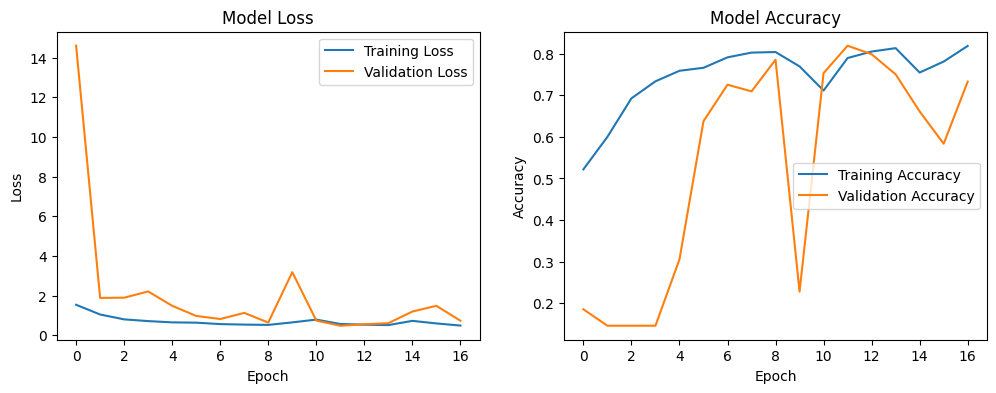

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_model_v1.history['loss'], label='Training Loss')
plt.plot(history_model_v1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_model_v1.history['accuracy'], label='Training Accuracy')
plt.plot(history_model_v1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##Matriz de Confusión (CNN preentrenada)

22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 265ms/step


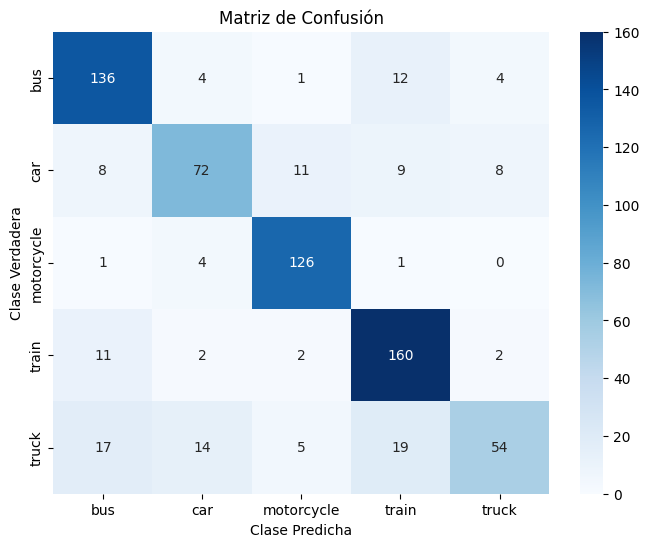

In [ ]:
# Obtener las etiquetas de clase predichas
y_pred_probs = model_v1.predict(X_test)  # El modelo devuelve probabilidades de pertenencia a cada clase
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Obtener la clase con mayor probabilidad

# Calcular la matriz de confusión
cm = confusion_matrix(Y_test, y_pred_classes)

# Definir las etiquetas de las clases
class_labels = ["bus", "car", "motorcycle", "train", "truck"]

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Matriz de Confusión')
plt.ylabel('Clase Verdadera')
plt.xlabel('Clase Predicha')
plt.show()

##Métricas de desempeño (CNN preentrenada)

In [ ]:
print(classification_report(Y_test, y_pred_classes, target_names=["bus", "car", "motorcycle", "train", "truck"]))

              precision    recall  f1-score   support

         bus       0.79      0.87      0.82       157
         car       0.75      0.67      0.71       108
  motorcycle       0.87      0.95      0.91       132
       train       0.80      0.90      0.85       177
       truck       0.79      0.50      0.61       109

    accuracy                           0.80       683
   macro avg       0.80      0.78      0.78       683
weighted avg       0.80      0.80      0.79       683



#Análisis resultados (CNN preentrenada)
El modelo de CNN preentrenada presenta un desempeño sólido en la clasificación de vehículos, alcanzando una exactitud global del 80%. Sin embargo, existen diferencias significativas en el rendimiento según la categoría. Algunas clases son identificadas con alta precisión, mientras que otras presentan confusiones recurrentes con tipos de vehículos similares.
A continuación, se detallan la clase mejor clasificada y la que presenta mayores dificultades.

La clase mejor clasificada es: "motorcycle"
- F1-score: 0.91 (el mejor de todas las clases).
- Precisión: 0.87 → El 87% de las veces que el modelo predijo "motorcycle", fue correcto.
- Recall: 0.95 → El 95% de las motocicletas reales fueron identificadas correctamente.
-Se confundió 4 veces con "car", y de a 1 vez fue clasificado erróneamente con "bus" y "train".
- Conclusión: El modelo distingue muy bien las motocicletas, con muy pocas confusiones.

La clase peor clasificada es: "truck"
- F1-score: 0.61 (el más bajo de todas las clases).
- Precisión: 0.79 → Cuando el modelo predice "truck", el 79% de las veces es correcto.
- Recall: 0.50 → Solo el 50% de los camiones reales fueron identificados correctamente.
-Se confunde con bus (17), car (14) y train (19), indicando que el modelo no logra diferenciar bien entre estos vehículos grandes.

#Conclusión
Luego de obtener los resultados de los modelos, se ve que la CNN preentrenada presenta una leve mejora, se pasó de un 76% del modelo original a un 80%, y la clase peor clasificada pasó de ser "car" a "truck", mientras que la clase "motorcycle" en ambos modelos se mantuvo como la mejor clasificada.
A pesar de que esta mejora en la exactitud no resulte significativa, hay que tener en cuenta que el entrenamiento de la CNN preentrada fue mucho más rápido, lo cual permitió ahorro de tiempo y recursos, siendo esta una mejora la cual debe ser considerada.